# BMEB W4020: Circuits in the Brain 2025 Fall Project \#2

*Author:* Shashwat Shukla <shashwat.shukla@columbia.edu>

Based on past work by Tingkai Liu and Cong Han

*Copyright 2025* Bionet Lab

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All). 
Make sure you fill up your name and collaborators below:

### Your names and UNI here

In this project, you will encode, decode and identify a biophysical neuron consisting of a dendritic tree, a soma, and a conductance-based axon hillock. The axon hillock is modelled as ON-OFF neurons in AER configuration.
<center><img src="figures/fig1.png" width=600 ></center>
<center><b>Figure 1</b>: Neuron modeled as [Filter]-[Encoder] Cascade.</center>

<center><img src="figures/fig2.png" width=600 ></center>
<center><b>Figure 2</b>: Dendritic processing: Two linear filters. Soma: ON-OFF encoder in AER configuration.</center>

## Problem 1

In this part, you will encode and decode a randomly generated input stimulus using the given neuron model when the dendritic filter is known to you. In particular, the dendritic filter is defined as $h_1(t) = 300 \cdot e^{-300\cdot t}$ and $h_2(t) = 200 \cdot e^{-200\cdot t}$. We further let $u_1 = u_2 = u$.

### Questions: 

1. (20 points) Encode a randomly generated signal $u(t)$ of bandwidth $50$ Hertz using the given neuron model, and plot the time-course of the membrane voltage of the soma. Also detect and label the spikes from the ON and OFF channels on the same plot.
2. (20 points) Use the detected spikes to decode the input signal $u(t)$. Plot the time-courses of the decoded and original input signal on the same plot to illustrate the quality of recovery. Also plot the time-course of the corresponding SNR between the signals.

In [1]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal as scipy_signal

def signal_generator(t, samples, sample_times, omega):
    signal = np.zeros_like(t)
    for s, st in zip(samples, sample_times):
        signal += omega / np.pi * s * np.sinc(omega / np.pi * (t - st))
    return signal

# Generate the input signal to the dendrite
f = 50  # Hertz
omega = 2 * np.pi * f
T = 2 * np.pi / omega
omega_pi = omega / np.pi
dt = 1e-6  # timestep (sec)
t = np.arange(0, 0.2, dt)

### Generate random bandlimited signal
np.random.seed(42)  # for reproducibility
num_samples = int(2 * f * t[-1]) + 1  # Nyquist sampling
sample_times = np.linspace(0, t[-1], num_samples)
samples = np.random.randn(num_samples)
u = signal_generator(t, samples, sample_times, omega)
u1 = u.copy()
u2 = u.copy()

In [2]:
# Generate the dendritic filters
t_filt = np.arange(0, 0.1, dt)

### Dendritic filters
h1 = 300 * np.exp(-300 * t_filt)
h2 = 200 * np.exp(-200 * t_filt)

# Normalize filters
h1 = h1 / (np.sum(h1) * dt)
h2 = h2 / (np.sum(h2) * dt)

In [3]:
# Compute the input signal to the axon hillock

### Convolve input with dendritic filters
v1 = np.convolve(u1, h1, mode='full')[:len(t)] * dt
v2 = np.convolve(u2, h2, mode='full')[:len(t)] * dt

# Soma integration: sum of filtered inputs
v = v1 + v2

In [4]:
# Normalize input before encoding
print("Normalizing input signal...")

u_mean = u.mean()
u_std = u.std()
u_normalized = (u - u_mean) / u_std

print(f"Original u: mean={u_mean:.4f}, std={u_std:.4f}")
print(f"Normalized u: mean={u_normalized.mean():.4f}, std={u_normalized.std():.4f}")
# Encode the input signal
delta = 0.2
kappa = 1.0

print("Encoding u(t) with IAF (integrate-and-fire)...")

tk = []
V = np.zeros_like(t)
integral = 0.0

for i in range(1, len(t)):
    # Integrate u(t) - NOT v(t)!
    integral += (u[i] + u[i-1]) / 2 * dt / kappa
    V[i] = integral
    
    if integral >= delta:
        tk.append(t[i])
        integral = 0.0
    elif integral <= -delta:
        tk.append(-t[i])
        integral = 0.0

tk = np.array(tk)
spike_times_on = tk[tk > 0]
spike_times_off = -tk[tk < 0]

print(f"Number of ON spikes: {len(spike_times_on)}")
print(f"Number of OFF spikes: {len(spike_times_off)}")
print(f"Total spikes: {len(tk)}")

Normalizing input signal...
Original u: mean=-15.0049, std=96.0001
Normalized u: mean=0.0000, std=1.0000
Encoding u(t) with IAF (integrate-and-fire)...
Number of ON spikes: 27
Number of OFF spikes: 42
Total spikes: 69


In [5]:
print(f"Using {len(tk)} spike times for reconstruction")


Using 69 spike times for reconstruction


In [6]:
# Estimate G matrix

print("Computing G matrix using cumulative sum method...")

tk_abs = np.abs(tk)
num_spikes = len(tk)

G = np.zeros((num_spikes, num_spikes))

for k in range(num_spikes):
    if k % 10 == 0:
        print(f"    Column {k}/{num_spikes}")
    
    sinc_k = (omega / np.pi) * np.sinc(omega / np.pi * (t - tk_abs[k]))
    csum = np.cumsum(sinc_k) * dt
    
    for l in range(num_spikes):
        if l == 0:
            t_start = 0
        else:
            t_start = tk_abs[l-1]
        t_end = tk_abs[l]
        
        idx_start = np.argmin(np.abs(t - t_start))
        idx_end = np.argmin(np.abs(t - t_end))
        
        if idx_start < idx_end:
            G[l, k] = csum[idx_end] - csum[idx_start]

print(f"G matrix shape: {G.shape}")

Computing G matrix using cumulative sum method...
    Column 0/69
    Column 10/69
    Column 20/69
    Column 30/69
    Column 40/69
    Column 50/69
    Column 60/69
G matrix shape: (69, 69)


In [7]:
# Estimate q vector
q = np.cumsum(np.sign(tk)) * delta
print(f"q vector shape: {q.shape}")

q vector shape: (69,)


In [8]:
# Decode and denormalize

print("Solving for reconstruction coefficients...")

rcond = 1e-4
G_inv = np.linalg.pinv(G, rcond=rcond)
c_rec = G_inv @ q

# Reconstruct normalized signal
u_normalized_reconstructed = signal_generator(t, c_rec, tk_abs, omega)

# Scale to match normalized std
scale_factor = u_normalized.std() / u_normalized_reconstructed.std()
u_normalized_reconstructed = u_normalized_reconstructed * scale_factor

# Denormalize back to original scale
u_reconstructed = u_normalized_reconstructed * u_std + u_mean

print(f"\nReconstruction complete!")
print(f"Original u: [{u.min():.2f}, {u.max():.2f}], std={u.std():.2f}")
print(f"Reconstructed u: [{u_reconstructed.min():.2f}, {u_reconstructed.max():.2f}], std={u_reconstructed.std():.2f}")
print(f"Correlation: {np.corrcoef(u, u_reconstructed)[0,1]:.4f}")

Solving for reconstruction coefficients...

Reconstruction complete!
Original u: [-229.67, 169.48], std=96.00
Reconstructed u: [-278.07, 233.52], std=96.00
Correlation: 0.2661


  Overall SNR: -1.81 dB


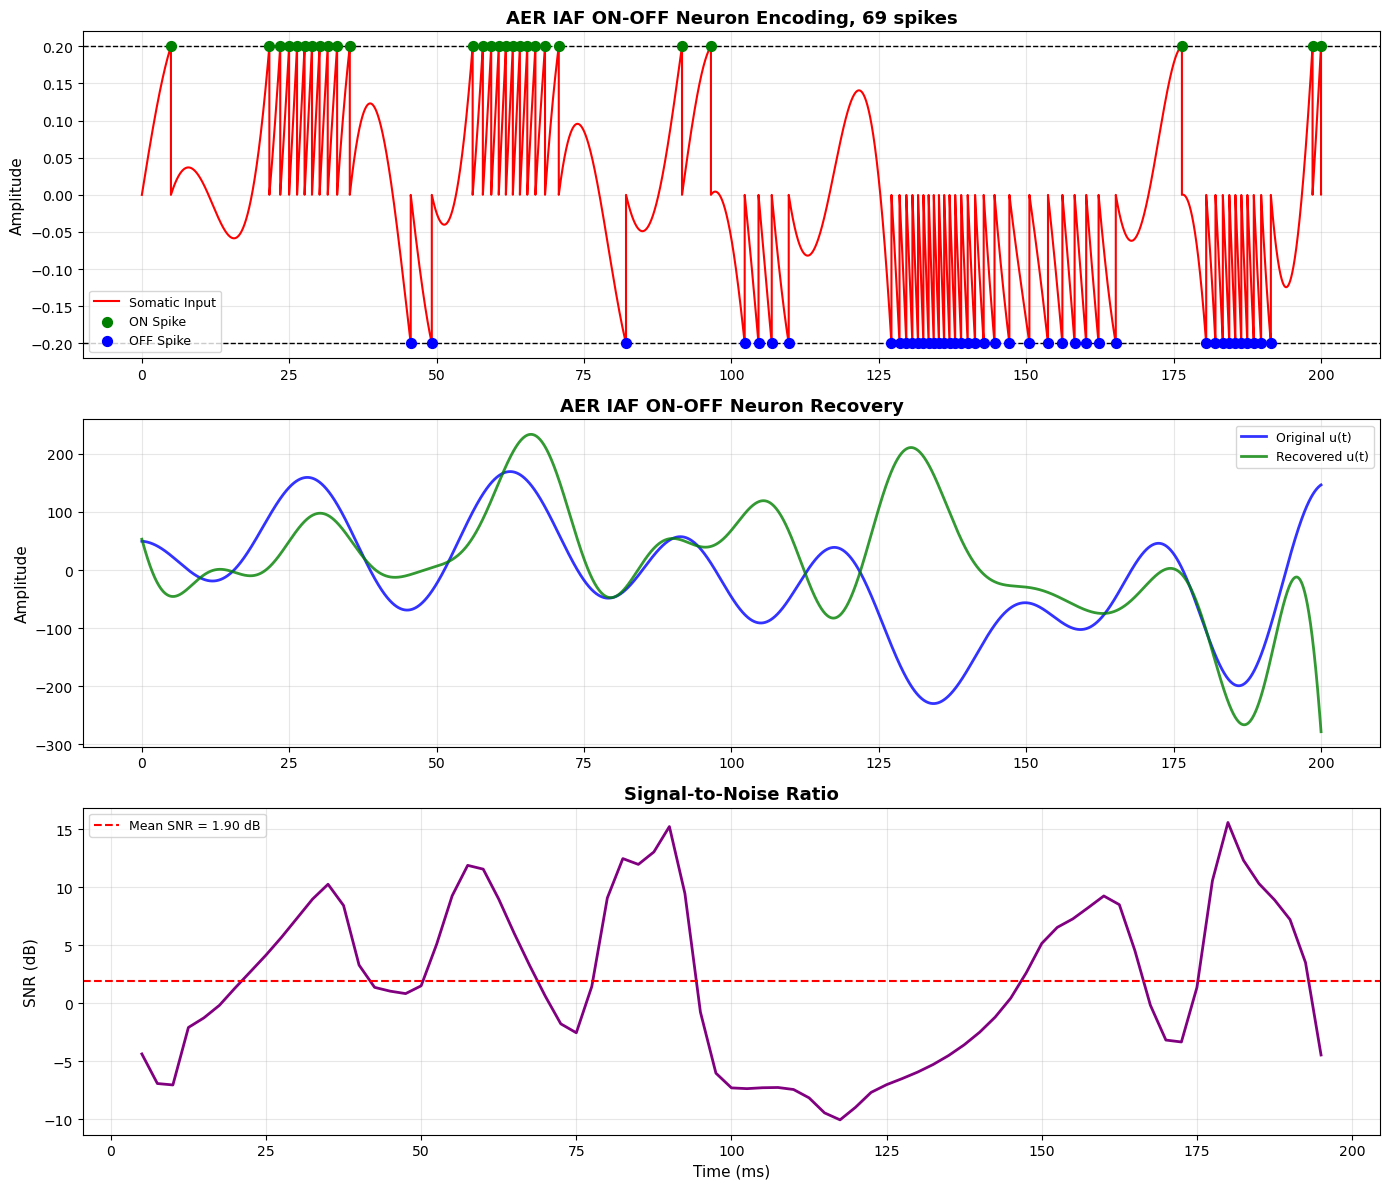


RECONSTRUCTION QUALITY METRICS
Overall SNR: -1.81 dB
Mean SNR: 1.90 dB
MSE: 1.432963e+04
Number of spikes: 69 (ON: 27, OFF: 42)
Correlation: 0.2661


In [9]:


# Calculate SNR
overall_snr = 10 * np.log10(np.mean(u**2) / np.mean((u - u_reconstructed)**2))
print(f"  Overall SNR: {overall_snr:.2f} dB")

# Plot results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Subplot 1: Encoding - membrane voltage with spikes
axes[0].plot(t * 1000, V, 'r-', linewidth=1.5, label='Somatic Input')
axes[0].axhline(y=delta, color='black', linestyle='--', linewidth=1)
axes[0].axhline(y=-delta, color='black', linestyle='--', linewidth=1)
axes[0].scatter(spike_times_on * 1000, np.ones_like(spike_times_on) * delta, 
                c='green', s=50, marker='o', zorder=5, label='ON Spike')
axes[0].scatter(spike_times_off * 1000, -np.ones_like(spike_times_off) * delta, 
                c='blue', s=50, marker='o', zorder=5, label='OFF Spike')
axes[0].set_ylabel('Amplitude', fontsize=11)
axes[0].set_title('AER IAF ON-OFF Neuron Encoding, {} spikes'.format(len(tk)), 
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=9, loc='lower left')
axes[0].grid(True, alpha=0.3)

# Subplot 2: Signal comparison
axes[1].plot(t * 1000, u, 'b-', linewidth=2, label='Original u(t)', alpha=0.8)
axes[1].plot(t * 1000, u_reconstructed, 'g-', linewidth=2, 
             label='Recovered u(t)', alpha=0.8)
axes[1].set_ylabel('Amplitude', fontsize=11)
axes[1].set_title('AER IAF ON-OFF Neuron Recovery', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=9, loc='upper right')
axes[1].grid(True, alpha=0.3)

# Subplot 3: SNR over time
window_size = 10000
snr_t = []
snr_values = []

for i in range(0, len(t) - window_size, window_size // 4):
    window_slice = slice(i, i + window_size)
    u_window = u[window_slice]
    u_rec_window = u_reconstructed[window_slice]
    
    signal_power = np.mean(u_window ** 2)
    noise_power = np.mean((u_window - u_rec_window) ** 2)
    
    if noise_power > 1e-12:
        snr_db = 10 * np.log10(signal_power / noise_power)
    else:
        snr_db = 100
    
    snr_t.append(t[i + window_size // 2])
    snr_values.append(snr_db)

axes[2].plot(np.array(snr_t) * 1000, snr_values, 'purple', linewidth=2)
axes[2].axhline(y=np.mean(snr_values), color='r', linestyle='--', 
                linewidth=1.5, label=f'Mean SNR = {np.mean(snr_values):.2f} dB')
axes[2].set_xlabel('Time (ms)', fontsize=11)
axes[2].set_ylabel('SNR (dB)', fontsize=11)
axes[2].set_title('Signal-to-Noise Ratio', fontsize=13, fontweight='bold')
axes[2].legend(fontsize=9)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary metrics
print(f"\n{'='*50}")
print(f"RECONSTRUCTION QUALITY METRICS")
print(f"{'='*50}")
print(f"Overall SNR: {overall_snr:.2f} dB")
print(f"Mean SNR: {np.mean(snr_values):.2f} dB")
print(f"MSE: {np.mean((u - u_reconstructed)**2):.6e}")
print(f"Number of spikes: {len(tk)} (ON: {len(spike_times_on)}, OFF: {len(spike_times_off)})")
print(f"Correlation: {np.corrcoef(u, u_reconstructed)[0,1]:.4f}")
print(f"{'='*50}")

## Problem 2

You are each given a black-box instance of the neuron described above (with name `neuron_uni.py`) that takes a time vector $t$ and an input signal $u$ as input arguments. 
- In "Dendrite" mode, the model first feeds $u$ to the dendritic tree, then passes the output of the dendritic tree to the axon hillock, and finally returns the spike train $\sum_k \delta(t-t_k)$ generated by the axon-hillock. In this case $u$ should be a 2D array with $u[0]=u_1, u[1]=u_2$.
- In "Axon" mode, $u$ is passed directly to the axon-hillock. In this case $u$ should be a 1D array of the same shape as $t$. 

The model given to you in `model_uni.py` can be used by doing the following:
```python
>>> from model_uni import model
>>> tk1 = model(t, np.array([u1, u2]), "Dendrite") # inject into dendritic tree
>>> tk2 = model(t, v, "Axon") # inject into axon-hillock
```

### Questions: 
Your task is to identify the circuit.
1. (20 points) We will start with identifying the AER unit. Inject the axon-hillock with appropriately chosen currents to verify that the firing threshold $\delta = 5e^{-5}$. Briefly explain your methodology. 
2. (40 points) Identify the two filters $(h^1(t),h^2(t))$ on $t\in [0,0.5]$[s] by generating random non-zero bandlimited input signals ${\bf u} = (u_1, u_2)$ in the _trignometric polynomial_ space. Choose any other parameters for your experiments as appropriate. 
    1. For a range of bandwidths $\Omega^i, i=1,2,\ldots$, identify the filters $\hat{h}_{1,i}, \hat{h}_{2,i}$ by using the input with corresponding bandwidth. Calculate the mean square error $\epsilon_i = MSE(\hat{h}_{1,i-1}, \hat{h}_{1,i}) + MSE(\hat{h}_{2,i-1}, \hat{h}_{2,i})$, where $\hat{h}_{1,0}=\hat{h}_{2,0}=0$.
    2. Plot $\epsilon_i$ v.s. $\Omega_i$. What do you find? Can you identify the effective bandwidth of the unknown dendritic processing filters? 

__Bonus__. (12.5 points) In HW5-Q2, you worked out the theory to estimate the filters $h_1, h_2$ _separately_, which you can use in Part 2 of this question. For this bonus question, write down the theory and simulate your results for _jointly_ estimating $h_1, h_2$ using two sets of randomly generated stimuli ${\bf u^1}$ and ${\bf u^2}$ wherein all the signals $u_1^1, u_2^1, u_1^2, u_2^2$ are _non-zero_.  


In [ ]:
import sys
sys.path.append('student')

In [ ]:
def cconv(
    u: np.ndarray, h: np.ndarray, dx: float = 1.0) -> np.ndarray:
    Nfft = max(len(u), len(h))
    v = dx * np.real(np.fft.ifft(np.fft.fft(u, n=Nfft) * np.fft.fft(h, n=Nfft)))
    return v[: len(u)]

In [ ]:
def getStimulusTrig(t, Omega, L, is_zero, M):
    if is_zero:  # returns a zero signal which can be useful for debugging
        ul = np.zeros(2 * L + 1)
    else:
        ul = np.random.rand(2 * L + 1)
        ul[:L] = np.conj(ul[::-1][:L])

    u = np.zeros_like(t)  # initialize the signal
    for l in range(-L, L + 1):
        u = u + ul[l + L] * np.exp(1j * l * Omega * t / L)
    u = np.real(u)

    # normalize
    max_u = np.max(np.abs(u))
    if max_u > 0:
        u = M * u / max_u
        ul = M * ul / max_u

    return u, ul

In [ ]:
# generate random signals in trigonometric polynomial space
dt = 1e-6
start_f = 1  # skip 1 period to avoid initial conditions
t = np.arange(0, (1 + start_f) * t_end, dt)  # set simulation time
L = 60
T = t_end
Omega = 2 * np.pi * L / T

### Your answer here ###

In [ ]:
# filter the input signals
### Your answer here ###

In [ ]:
# encode the filtered signal
### Your answer here ###

In [ ]:
# compute Phi
### Your answer here ###

In [ ]:
# decode
### Your answer here ###

In [ ]:
# recover
### Your answer here ###

In [ ]:
# plot results
### Your answer here ###